# Survival Analysis Tutorial Part 1

In this tutorial we will introduce:

- what is **right-censored time-to-event data** and why naive regression models fail on such data,
- **unconditional survival analysis** with the **Kaplan-Meier** estimator,
- **predictive survival analysis** with Cox Proportional Hazards, Survival Forests and Gradient Boosted CIF,
- how to assess the quality of survival estimators using the Integrated Brier Score and C-index metrics,
- what is **right-censored competing risks data**,
- **unconditional competing risks analysis** with the **Aalen-Johansen** estimator,
- **predictive competing risks analysis** with gradient boosted CIF.

## Tutorial data

To run this tutorial you can **either generate or download** the truck failure data.

**To generate the data**, open the `truck_data.ipynb` notebook in jupyter lab and click the "run all" (fast forward arrow) button and wait a few minutes. By the end, you should see a bunch of `.parquet` and `.npz` files showing up in the `notebooks` folder.

Alternatively, feel free **to download** a zip archive from:

- https://github.com/soda-inria/survival-analysis-benchmark/releases/download/jupytercon-2023-tutorial-data/truck_failure.zip (a bit more than 500 MB).

and unzip it in the `notebooks` folder.

## What is right-censored time-to-event data?

### Censoring

Survival analysis is a time-to-event regression problem, with censored data. We call censored all individuals that didn't experience the event during the range of the observation window.

In our setting, we're mostly interested in right-censored data, meaning we that the event of interest did not occur before the end of the observation period (typically the time of collection of the dataset):

<figure>
<img src="notebooks/censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or may not be ended by the time of observation.

Survival analysis techniques have wide applications:

- In the **medical** landscape, events can consist in patients dying of cancer, or on the contrary recovering from some disease.
- In **predictive maintenance**, events can consist in machine failure.
- In **insurance**, we are interesting in modeling the time to next claim for a portfolio of insurance contracts.
- In **marketing**, we can consider user churning as events, or we could focus on users becoming premium (members that choose to pay a subscription after having used the free version of service for a while).
- **Economists** my be interesting in modeling the time for unemployed people to find a new job in different context or different kinds of jobs.


As we will see, for all those applications, it is not possible to directly train a machine learning-based regression model on such a **right-censored** time-to-event target since we only have a lower bound on the true time to event for some data points. **Naively removing such points from the dataset would cause the model predictions to be biased**.

### Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of two elements:

- The event indicator $\delta_i\in\{0, 1\}$, where $0$ marks censoring and $1$ is indicative that the event of interest has actually happened before the end of the observation window.
- The censored time-to-event $d_i=min(t_{i}, c_i) > 0$, that is the minimum between the date of the experienced event $t_i$ and the censoring date $c_i$. In a real-world setting, we don't have direct access to $t_i$ when $\delta_i=0$. We can only record $d_i$.

Here is how we represent our target:

In [2]:
import pandas as pd
import numpy as np

truck_failure_events = pd.read_parquet("truck_failure/truck_failure_10k_any_event.parquet")
truck_failure_events

,event,duration
0,True,980.394661
1,True,1207.870100
2,False,125.000000
3,True,96.839004
4,True,88.077852
...,...,...
9995,True,0.435731
9996,True,356.591211
9997,True,847.951259
9998,True,25.551167


In this example, we study the accident of truck-driver pairs. Censored pairs (when event is 0 or False) haven't had a mechanical failure or an accident during the study.

### Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two naive options to deal with right-censored time to event data:
- We ignore censorted data points from the dataset, only keep events that happened and perform naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average and median time to event using either of those naive approaches on our truck failure dataset. We will compare them to the mean of the ground-truth event time $T$, that we would obtained with an infinite observation window. 

Note that we have access to the random variable $T$ because we generated this synthetic dataset. With real-world data, you only have access to $Y = \min(T, C)$, where $C$ is a random variable representing the censoring time.

In [3]:
naive_stats_1 = (
    truck_failure_events.query("event == True")["duration"]
    .apply(["mean", "median"])
)
print(
    f"Biased method 1 (removing censored points):\n"
    f"mean: {naive_stats_1['mean']:.1f} days, "
    f"median: {naive_stats_1['median']:.1f} days"
)

Biased method 1 (removing censored points):
mean: 597.8 days, median: 413.0 days


In [4]:
max_duration = truck_failure_events["duration"].max()
naive_stats_2 = (
    pd.Series(
        np.where(
            truck_failure_events["event"],
            truck_failure_events["duration"],
            max_duration,
        )
    )
    .apply(["mean", "median"])
)
print(
    f"Biased method 2 (censored events moved to the end of the window):\n"
    f"mean: {naive_stats_2['mean']:.1f} days, "
    f"median: {naive_stats_2['median']:.1f} days"
)

Biased method 2 (censored events moved to the end of the window):
mean: 1031.2 days, median: 909.6 days


In our case, the **data comes from a simple truck fleet simulator** and we have **access to the uncensored times** (we can wait as long as we want to extend the observation period as needed to have all trucks fail).

Let's have a look at the **true mean and median time-to-failure**:

In [5]:
truck_failure_events_uncensored = pd.read_parquet("truck_failure/truck_failure_10k_any_event_uncensored.parquet")

In [6]:
true_stats = truck_failure_events_uncensored["duration"].apply(["mean", "median"])
print(
    f"Ground truth (from the simulator):\n"
    f"mean: {true_stats['mean']:.2f} days, "
    f"median: {true_stats['median']:.2f} days"
)

Ground truth (from the simulator):
mean: 869.79 days, median: 735.45 days


We see that **neither of the naive ways to handle censoring gives a good estimate of the true mean or median time to event**.

If we have access to covariates $X$ (also known as input features in machine learning), a regression method would try to estimate $\mathbb{E}[T|X]$, where $X$ are our covariates, but we only have access to $Y = \min(T, C)$ where $T$ is the true time to failure and $C$ is the censoring duration. Fitting a **conditional regression model on right-censored data** would also require a special treatment because either of the **naive preprocessing** presented above would introduce a **significant bias in the predictions**.


Here is structured outline of the estimators we will introduce in this tutorial:


|                                          | Descriptive / unconditional: only `y`, no `X`        | Predictive / conditional: `y` given  `X`        |
|------------------------------------------|------------------------------------------------------|-------------------------------------------------|
| Suvival Analysis (1 event type)          | Kaplan-Meier                                         | Cox PH, Survival Forests, SurvivalBoost |
| Competing Risks Analysis (k event types) | Aalen-Johansen                                       | SurvivalBoost                           |


Let's start with unconditional estimation of the any event survival curve.


## Unconditional survival analysis with Kaplan-Meier

We now introduce the survival analysis approach to the problem of estimating the time-to-event from censored data. For now, we ignore any information from $X$ and focus on $y$ only.

Here our quantity of interest is the survival probability:

$$S(t)=P(T > t)$$ 

This represents the probability that an event doesn't occur at or before some given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the **Kaplan-Meier** estimator. It gives us an **unbiased estimate of the survival probability**. It can be computed as follows:

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where:

- $t_i$ is the time of event for individual $i$ that experienced the event,
- $d_i$ is the number of individuals having experienced the event at $t_i$,
- $n_i$ are the remaining individuals at risk at $t_i$.

Note that **individuals that were censored before $t_i$ are no longer considered at risk at $t_i$**.

Contrary to machine learning regressors, this estimator is **unconditional**: it only extracts information from $y$ only, and cannot model information about each individual typically provided in a feature matrix $X$.

In a real-world application, we aim at estimating $\mathbb{E}[T]$ or $Q_{50\%}[T]$. The latter quantity represents the median survival duration i.e. the duration before 50% of our population at risk experiment the event.

We can also be interested in estimating the survival probability after some reference time $P(T > t_{ref})$, e.g. a random clinical trial estimating the capacity of a drug to improve the survival probability after 6 months.

In [7]:
import plotly.express as px
from sksurv.nonparametric import kaplan_meier_estimator


times, km_survival_probabilities = kaplan_meier_estimator(
    truck_failure_events["event"], truck_failure_events["duration"]
)

In [8]:
times

array([0.00000000e+00, 2.19053031e-03, 4.04568029e-02, ...,
       1.99600000e+03, 1.99800000e+03, 2.00000000e+03])

In [9]:
km_survival_probabilities

array([1.        , 0.99989999, 0.99979998, ..., 0.07412087, 0.07412087,
       0.07412087])

In [10]:
km_proba = pd.DataFrame(
    dict(
        time=times,
        survival_curve=km_survival_probabilities
    )
)
fig = px.line(
    km_proba,
    x="time",
    y="survival_curve",
    title="Kaplan-Meier survival probability",
)
fig.add_hline(
    y=0.50,
    annotation_text="Median",
    line_dash="dash",
    line_color="red",
    annotation_font_color="red",
)

fig.update_layout(
    height=500,
    width=800,
    xaxis_title="time (days)",
    yaxis_title=r"$\hat{S}(t)$ ",
    yaxis_range=[0, 1],
)

We can read the median time to event directly from this curve: it is the time at the intersection of the estimate of the survival curve with the horizontal line for a 50% failure probility.

Since we have censored data, $\hat{S}(t)$ doesn't reach 0 within our observation window. We would need to extend the observation window to estimate the survival function beyond this limit. **Kaplan-Meier does not attempt the extrapolate beyond the last observed event**.

***Exercice*** <br>
Based on `times` and `km_survival_probabilities`, estimate the median survival time.

*Hint: You can use `np.searchsorted` on sorted probabilities in increasing order (reverse the natural order of the survival probabilities*.

*Hint: Alternatively you can "inverse" the estimate of the survival curve using `scipy.interpolate.interp1d` and take the value at probability 0.5.*

In [11]:
def compute_median_survival_time(times, survival_probabilities):
    """Get the closest time to a survival probability of 50%."""
    ### Your code here
    median_survival_time = 0
    ###
    return median_survival_time












compute_median_survival_time(times, km_survival_probabilities)

0

Here is the **true median survival time from the same data without any censoring** (generally not avaible in a real life setting).

In [12]:
truck_failure_events_uncensored["duration"].median().round(decimals=1)

735.4

This empirically confirms that the median survival time estimated by post-processing the KM estimate of the survival curve is a much better way to handle censored data than any the two naive approaches we considered in the beginning of this notebook.

### Mathematical break

We now introduce some quantities which are going to be at the core of many survival analysis models and Kaplan-Meier in particular.

The most important concept is the hazard rate $\lambda(t)$. This quantity represents the "speed of failure" or **the probability that an event occurs in the next $dt$, given that it hasn't occured yet**. This can be written as:

$$\begin{align}
\lambda(t) &=\lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt | P(T \geq t))}{dt} \\
&= \lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt)}{dtS(t)} \\
&= \frac{f(t)}{S(t)}
\end{align}
$$

where $f(t)$ represents the event density function, independently of wheter the event has happened before or not.

If we integrate $f(t)$, we get the cumulative incidence function (CIF) $F(t)=P(T < t)$, which is the complement of the survival function $S(t)$:

$$F(t) = 1 - S(t) = \int^t_0 f(u) du$$

Most of the time we do not attempt to evaluate $f(t)$. Instead we usually define the cumulative hazard function by integrating the hazard function:

$$\Lambda(t) = \int^t_0 \lambda(u) du$$

It can be shown that the survival function (and therefore the cumulative incidence function) can be computed as:

$$S(t) = e^{-\Lambda(t)}$$

$$F(t) = 1 - e^{-\Lambda(t)}$$

and if we have an estimate of $S(t)$ we can derive estimates of the cumulative hazard and instantenous hazard functions as:

$$\Lambda(t) = - log(S(t))$$

$$\lambda(t) = - \frac{S'(t)}{S(t)}$$

In practice, estimating the hazard function from a finite sample estimate of the survival curve can be quite challenging (from a numerical point of view). But the converse often works well.

Since our dataset was sampled from known hazard functions (one per truck), we can compute the theoretical survival curve by integrating over the time and taking the exponential of the negative. Let's give this a try:

In [13]:
with np.load("truck_failure/truck_failure_10k_hazards.npz") as f:
    theoretical_hazards = f["truck_failure_10k_hazards"].sum(axis=0)  # will be explained later

theoretical_hazards.shape

(10000, 3650)

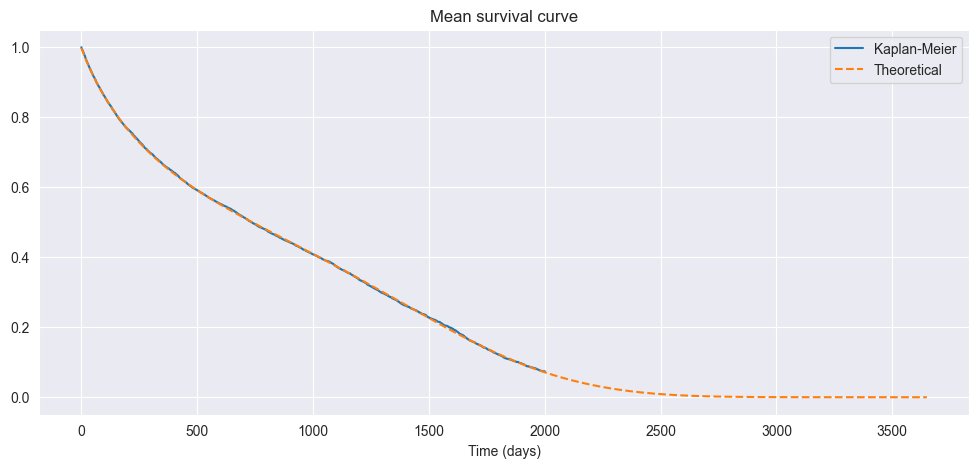

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")


theoretical_cumulated_hazards = theoretical_hazards.cumsum(axis=-1)
mean_theoretical_survival_functions = np.exp(-theoretical_cumulated_hazards).mean(axis=0)
n_time_steps = mean_theoretical_survival_functions.shape[0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(times, km_survival_probabilities, label="Kaplan-Meier")
ax.plot(
    np.arange(n_time_steps), mean_theoretical_survival_functions,
    linestyle="--", label="Theoretical"
)
ax.set(title="Mean survival curve", xlabel="Time (days)")
ax.legend();

We observe that **Kaplan-Meier is an unbiased estimator of the survival curve** defined by the true hazard functions.

However we observe that then **KM estimate is no longer defined after the time of the last observed failure** (day 2000 in our case). In this dataset, all events are censored past that date: as a result **the KM survival curve does not reach zero** even when the true curve does. Therefore, it is **not possible to compute the mean survival time from the KM-estimate** alone. One would need to make some further assumptions to extrapolate it if necessary.

Furthermore, not all data generating process necessarily need to reach the 0.0 probability. For instance, survival analysis could be used to model a "time to next snow event" in different regions of the world. We can anticipate that it will never snow in some regions of the world in the foreseeable future.

### Kaplan-Meier on subgroups: stratification on columns of `X`

We can enrich our analysis by introducing covariates, that are statistically associated to the events and durations.

In [15]:
truck_failure_features = pd.read_parquet("truck_failure/truck_failure_10k_features.parquet")
truck_failure_features

,driver_skill,brand,truck_model,usage_rate
0,0.6,Cheapz,C3,0.80
1,0.8,Robusta,RA,0.50
2,0.7,Robusta,RB,0.55
3,0.6,Cheapz,C3,0.31
4,0.5,Cheapz,C1,0.75
...,...,...,...,...
9995,0.6,Robusta,RA,0.76
9996,0.5,Robusta,RB,0.75
9997,0.8,Cheapz,C2,0.64
9998,0.2,Cheapz,C1,0.63


In [16]:
truck_failure_features_and_events = pd.concat(
    [truck_failure_features, truck_failure_events], axis="columns"
)
truck_failure_features_and_events

,driver_skill,brand,truck_model,usage_rate,event,duration
0,0.6,Cheapz,C3,0.80,True,980.394661
1,0.8,Robusta,RA,0.50,True,1207.870100
2,0.7,Robusta,RB,0.55,False,125.000000
3,0.6,Cheapz,C3,0.31,True,96.839004
4,0.5,Cheapz,C1,0.75,True,88.077852
...,...,...,...,...,...,...
9995,0.6,Robusta,RA,0.76,True,0.435731
9996,0.5,Robusta,RB,0.75,True,356.591211
9997,0.8,Cheapz,C2,0.64,True,847.951259
9998,0.2,Cheapz,C1,0.63,True,25.551167


For exemple, let's use Kaplan Meier to get a sense of the impact of the **brand**, by stratifying on this variable.

***Exercice***

Plot the stratified Kaplan Meier of the brand, i.e. for each different brand:
1. Filter the dataset on this brand using pandas, for instance by using boolean masking or using the `.query` method of the dataframe;
2. Estimate the survival curve with Kaplan-Meier on each subset;
3. Plot the survival curve for each subset.

What are the limits of this method?

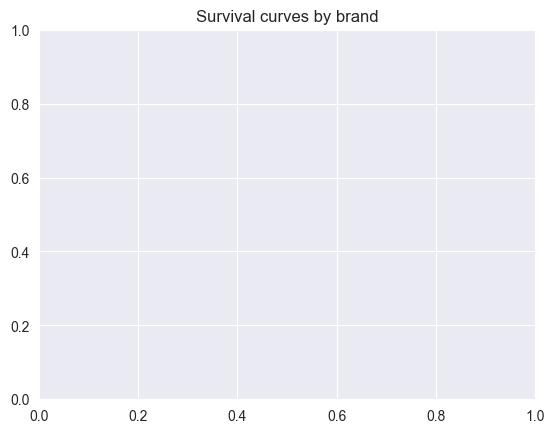

In [17]:
import matplotlib.pyplot as plt


def plot_km_curve_by_brand(df):
    brands = df["brand"].unique()
    fig_data = []
    for brand in brands:
        # TODO: replace the following by your code here:
        pass

    plt.title("Survival curves by brand")

    
plot_km_curve_by_brand(truck_failure_features_and_events)

We can observe that drivers of "Cheapz" trucks seem to experiment a higher number of failures in the early days but then the cumulative number of failures for each group seem to become comparable.

The stratified KM method is nice to compare two groups but quickly becomes impracticable as the number of covariate groups grow. We need estimator that can handle covariates.

Let's now attempt to quantify how a survival curve estimated on a training set performs on a test set.

## Survival model evaluation using the Integrated Brier Score (IBS) and the Concordance Index (C-index)

The Brier score and the C-index are measures that **assess the quality of a predicted survival curve** on a finite data sample.

- **The Brier score is a proper scoring rule**, meaning that an estimate of the survival curve has minimal Brier score if and only if it matches the true survival probabilities induced by the underlying data generating process. In that respect the **Brier score** assesses both the **calibration** and the **ranking power** of a survival probability estimator.

- On the other hand, the **C-index** only assesses the **ranking power**: it is invariant to a monotonic transform of the survival probabilities. It only focus on the ability of a predictive survival model to identify which individual is likely to fail first out of any pair of two individuals.



It is comprised between 0 and 1 (lower is better).
It answers the question "how close to the real probabilities are our estimates?".

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(d_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(d_i)} + I(d_i > t)
        \frac{(1 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$$
    
In the survival analysis context, the Brier Score can be seen as the Mean Squared Error (MSE) between our probability $\hat{S}(t)$ and our target label $\delta_i \in {0, 1}$, weighted by the inverse probability of censoring $\frac{1}{\hat{G}(t)}$. In practice we estimate $\hat{G}(t)$ using a variant of the Kaplan-Estimator with swapped event indicator.

- When no event or censoring has happened at $t$ yet, i.e. $I(d_i > t)$, we penalize a low probability of survival with $(1 - \hat{S}(t|\mathbf{x}_i))^2$.
- Conversely, when an individual has experienced an event before $t$, i.e. $I(d_i \leq t \land \delta_i = 1)$, we penalize a high probability of survival with $(0 - \hat{S}(t|\mathbf{x}_i))^2$.
    
<figure>
<img src="BrierScore.svg" style="width:80%">
</figure>
    
</details>

Let's put this in practice. We first perform a train test split so as to fit the estimator on a traing sample and compute the performance metrics on a held-out test sample. Due to restructions of some estimators in scikit-survival, we ensure that all the test data points lie well within the time range observed in the training set.

In [18]:
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X = truck_failure_features
y = truck_failure_events

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

Let's estimate the survival curve on the training set:

In [19]:
km_times_train, km_survival_curve_train = kaplan_meier_estimator(
    y_train["event"], y_train["duration"]
)

The `km_times_train` are ordered event (or censoring) times actually observed on the training set. To be able to compare that curve with curves computed on another time grid, we can use step-wise constant interpolation:

In [20]:
from scipy.interpolate import interp1d


km_predict = interp1d(
    km_times_train,
    km_survival_curve_train,
    kind="previous",
    bounds_error=False,
    fill_value="extrapolate",
)


def make_test_time_grid(y_train, n_steps=300):
    """Bound times to the range of duration."""
    # Some survival models can fail to predict near the boundary of the
    # range of durations observed on the training set.
    observed_duration = y_test.query("event > 0")["duration"]
    
    # trim 1% of the span, 0.5% on each end:
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)


time_grid = make_test_time_grid(y_train)

Kaplan-Meier is a constant predictor: it always estimates the mean survival curve for all individual in the (training) dataset: the estimated survival curve does not depend on features values of the `X_train` or `X_test` matrices.

To be able to compare the Kaplan-Meier estimator with conditional estimators who estimate indivudual survival curves for each row in `X_train` or `X_test` we treat KM as a constant predictor that always output the same survival curve as many times as there are rows in `X_test`:

In [21]:
km_curve = km_predict(time_grid)
y_pred_km_test = np.vstack([km_curve] * X_test.shape[0])

We can now compute on value of the Brier score for each time horizon in the test time grid using the values in `y_test` as ground truth targets using `sksurv.metrics.brier_score`. At this time, scikit-survival expects the `y` arguments to be passed as numpy record arrays instead of pandas dataframes:

In [22]:
from sksurv.metrics import brier_score


def as_sksurv_recarray(y_frame):
    """Return scikit-survival's specific target format."""
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[("event", np.bool_), ("duration", np.float64)],
    )
    y_recarray["event"] = y_frame["event"]
    y_recarray["duration"] = y_frame["duration"]
    return y_recarray


_, km_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)

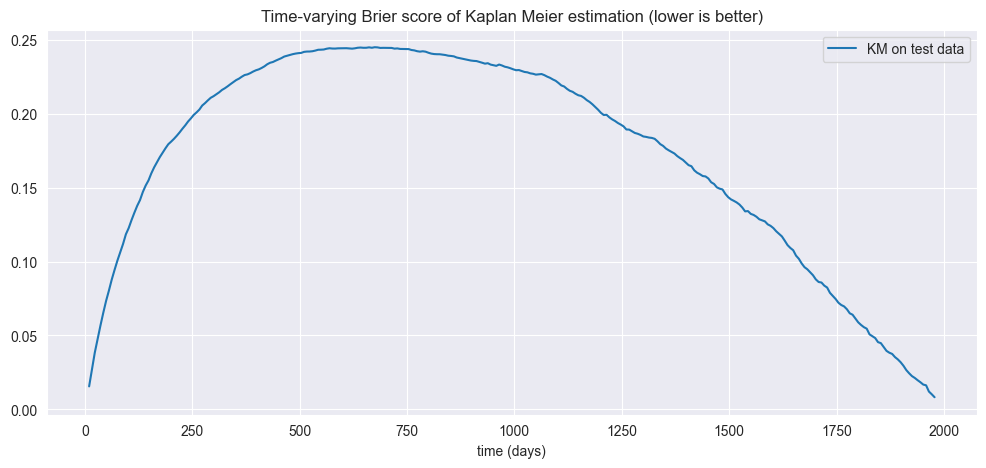

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_grid, km_brier_scores, label="KM on test data");
ax.set(
    title="Time-varying Brier score of Kaplan Meier estimation (lower is better)",
    xlabel = "time (days)",
)
ax.legend();

We observed that the "prediction error" is largest for time horizons between 200 and 1500 days after the beginning of the observation period.


Additionnaly, we compute the Integrated Brier Score (IBS) which we will use to summarize the Brier score curve and compare the quality of different estimators of the survival curve on the same test set:
$$IBS = \frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} BS(t) dt$$

In [24]:
from sksurv.metrics import integrated_brier_score

km_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)
print(f"IBS of Kaplan-Meier estimator on test set: {km_ibs_test:.3f}")

IBS of Kaplan-Meier estimator on test set: 0.174


Since the KM estimator always predicts the same constant survival curve for any samples in `X_train` or `X_test`, it's quite a limited model: it cannot rank individual by estimated median time to event for instance. Still, it's an interesting baseline because it's well calibrated among all the constant survival curve predictors.

For instance we could compare to a model that would predict a linear decrease of the survival probability over time and measure the IBS on the same test data. The KM-survival curve is hopefully better than such a dummy predictor:

In [25]:
linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = [linear_survival_curve] * y_test.shape[0]

linear_survival_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=constant_linear_survival_curves,
    times=time_grid,
)
print(f"IBS of linear survival estimator on test set: {linear_survival_ibs_test:.3f}")

IBS of linear survival estimator on test set: 0.185


Finally, let's also **introduce the concordance index (C-index)**. This metric evaluates the ranking (or discriminative) power of a model by comparing pairs of individuals having experienced the event. The C-index of a pair $(i, j)$ is maximized when individual $i$ has experienced the event before $j$ and the estimated risk of $i$ is higher than the one of $j$. 

This metric is also comprised between 0 and 1 (higher is better), 0.5 corresponds to a random prediction.

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{C_{index}} = \frac{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1 \space \land \space \mu_i < \mu_j)}{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1)}$$

Let's introduce the cumulative hazards $\Lambda(t)$, which is the negative log of the survival function $S(t)$:

$$S(t) = \exp(-\Lambda(t)) = \exp(-\int^t_0 \lambda(u)du)$$
    
Therefore:
    
$$\Lambda(t) = -\log(S(t))$$

Finally, the risk is obtained by summing over the entire cumulative hazard:
    
$$\mu_i = \int^{t_{max}}_{t_{min}} \Lambda(t, x_i) dt = \int^{t_{max}}_{t_{min}} - \log (S(t, x_i)) dt$$
    
</details>

To compute the C-index of our Kaplan Meier estimates, we assign every individual with the same survival probabilities given by the Kaplan Meier.

In [26]:
from sksurv.metrics import concordance_index_censored


def compute_c_index(event, duration, survival_curves):
    survival_curves = np.asarray(survival_curves)
    if survival_curves.ndim != 2:
        raise ValueError(
            "`survival_probs` must be a 2d array of "
            f"shape (n_samples, times), got {survival_curves.shape}"
        )
    assert event.shape[0] == duration.shape[0], survival_curves.shape[0]

    # Cumulative hazard is also known as risk.
    cumulative_hazard = survival_to_risk_estimate(survival_curves)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]


def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

In [27]:
km_c_index_test = compute_c_index(y_test["event"], y_test["duration"], y_pred_km_test)
km_c_index_test

0.5

This is equivalent to a random prediction. Indeed, as our Kaplan Meier is a unconditional estimator: it can't be used to rank individuals predictions as it predicts the same survival curve for any row in `X_test`.

Before moving forward, let's define a helper function that consolidates all the evaluation code together:

,Model,IBS,C-index
0,Constant linear,0.1854,0.5
1,Kaplan-Meier,0.1739,0.5


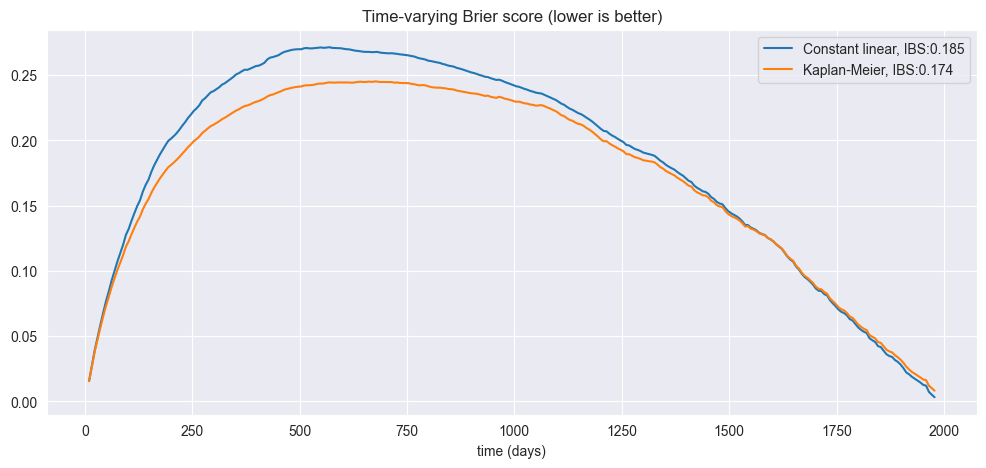

In [28]:
class SurvivalAnalysisEvaluator:
    
    def __init__(self, y_train, y_test, time_grid):
        self.model_data = {}
        self.y_train = as_sksurv_recarray(y_train)
        self.y_test = as_sksurv_recarray(y_test)
        self.time_grid = time_grid
        
    def add_model(self, model_name, survival_curves):
        survival_curves = np.asarray(survival_curves)
        _, brier_scores = brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        ibs = integrated_brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        c_index = compute_c_index(
            self.y_test["event"],
            self.y_test["duration"],
            survival_curves,
        )
        self.model_data[model_name] = {
            "brier_scores": brier_scores,
            "ibs": ibs,
            "c_index": c_index,
            "survival_curves": survival_curves,
        }

    def metrics_table(self):
        return pd.DataFrame([
            {
                "Model": model_name,
                "IBS": info["ibs"],
                "C-index": info["c_index"],
            }
            for model_name, info in self.model_data.items()
        ]).round(decimals=4)
        
    def plot(self, model_names=None):
        if model_names is None:
            model_names = list(self.model_data.keys())
        fig, ax = plt.subplots(figsize=(12, 5))
        self._plot_brier_scores(model_names, ax=ax)

    def _plot_brier_scores(self, model_names, ax):
        for model_name in model_names:
            info = self.model_data[model_name]
            ax.plot(
                self.time_grid,
                info["brier_scores"],
                label=f"{model_name}, IBS:{info['ibs']:.3f}");
        ax.set(
            title="Time-varying Brier score (lower is better)",
            xlabel="time (days)",
        )
        ax.legend()
        
    def __call__(self, model_name, survival_curves, model_names=None):
        self.add_model(model_name, survival_curves)
        self.plot(model_names=model_names)
        return self.metrics_table()

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan-Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

Next, we'll study how to fit survival models that make predictions that depend on the covariates $X$.

## Predictive survival analysis

### Cox Proportional Hazards

The Cox PH model is the most popular way of dealing with covariates $X$ in survival analysis. It computes a log linear regression on the target $Y = \min(T, C)$, and consists in a baseline term $\lambda_0(t)$ and a covariate term with weights $\beta$.
$$\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top \beta)$$

Note that only the baseline depends on the time $t$, but we can extend Cox PH to time-dependent covariate $x_i(t)$ and time-dependent weigths $\beta(t)$. We won't cover these extensions in this tutorial.

This methods is called ***proportional*** hazards, since for two different covariate vectors $x_i$ and $x_j$, their ratio is:
$$\frac{\lambda(t, x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t) e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$$

This ratio is not dependent on time, and therefore the hazards are proportional.

Let's run it on our truck-driver dataset using the implementation of `sksurv`. This models requires preprocessing of the categorical features using One-Hot encoding. Let's use the scikit-learn column-transformer to combine the various components of the model as a pipeline:

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis

simple_preprocessor = make_column_transformer(
    (OneHotEncoder(), ["brand", "truck_model"]),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
cox_ph = make_pipeline(
    simple_preprocessor,
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
cox_ph.fit(X_train, as_sksurv_recarray(y_train))

/Users/jalberge/anaconda3/envs/donnees_censurees/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

Let's compute the predicted survival functions for each row of the test set `X_test` and plot the first 5 survival functions:

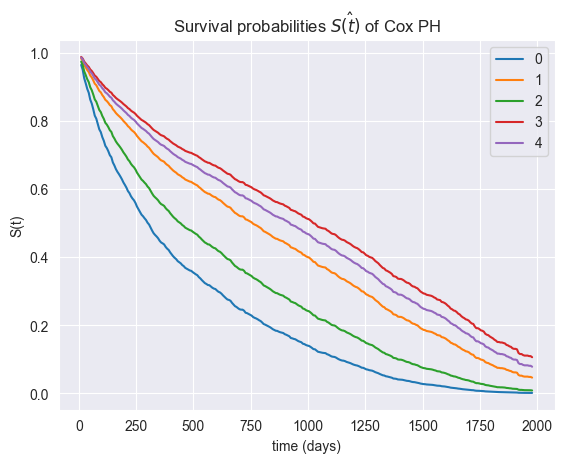

In [30]:
cox_ph_survival_funcs = cox_ph.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:5]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)
ax.set(
    title="Survival probabilities $\hat{S(t)}$ of Cox PH",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

Those estimated survival curves are predicted for the following test datapoints:

In [31]:
X_test.head(5).reset_index(drop=True)

,driver_skill,brand,truck_model,usage_rate
0,0.3,Cheapz,C2,0.62
1,0.5,Cheapz,C2,0.33
2,0.8,Robusta,RA,0.77
3,0.7,Cheapz,C3,0.83
4,0.7,Cheapz,C2,0.44


We see that predicted survival functions can vary significantly for different test samples.

There are two ways to read this plot:

First we could consider our **predictive survival analysis model as a probabilistic regressor**: if we want to **consider a specific probability of survival, say 50%**, we can mentally draw an horizontal line at 0.5, and see that:

- test data point `#0` has an estimated median survival time around 300 days,
- test data point `#1` has an estimated median survival time around 800 days,
- test data point `#2` has an estimated median survival time around 450 days...

Secondly we could also consider our **predictive survival analysis model as a probabilistic binary classifier**: if we **consider a specific time horizon, say 1000 days**, we can see that:

- test data point `#0` has less than a 20% chance to remain event-free at day 1000,
- test date point `#3` has around a 50% chance to remain event-free at day 1000...


Let's try to get some intuition about the features importance from the first 5 truck-driver pairs and their survival probabilities.

***Exercice***

Find out which features have the strongest positive or negative impact on the predictions of the model by matching the fitted coefficients $\beta$ of the model (stored under `_coef`) with their names from the `get_feature_names_out()` method of the preprocessor.

*Hint*: You can access each step of a scikit-learn pipeline as simply as `pipeline[step_idx]`.

In [32]:
cox_ph  # the full pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

In [33]:
cox_ph[0]  # the first step of the pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['brand', 'truck_model'])],
                  verbose_feature_names_out=False)

In [34]:
cox_ph[1]  # the second step of the pipeline

CoxPHSurvivalAnalysis(alpha=0.0001)

In [35]:
### Your code here




feature_names = []
weights = []



###

#### Solution

In [36]:
feature_names = cox_ph[-2].get_feature_names_out()
feature_names.tolist()

['brand_Cheapz',
 'brand_Robusta',
 'truck_model_C1',
 'truck_model_C2',
 'truck_model_C3',
 'truck_model_RA',
 'truck_model_RB',
 'driver_skill',
 'usage_rate']

In [37]:
weights = cox_ph[-1].coef_
weights

array([ 0.037121  , -0.03712099,  0.42027449,  0.15282552, -0.53597901,
        0.54881995, -0.58594094, -1.72754336,  1.43987448])

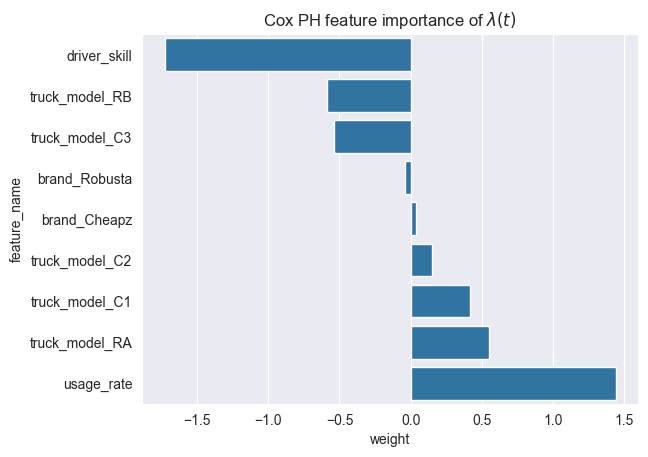

In [38]:
features = (
    pd.DataFrame(
        dict(
            feature_name=feature_names,
            weight=weights,
        )
    )
    .sort_values("weight")
)
ax = sns.barplot(features, y="feature_name", x="weight", orient="h")
ax.set_title("Cox PH feature importance of $\lambda(t)$");

#### End solution

Finally, we compute the Brier score for our model.

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902


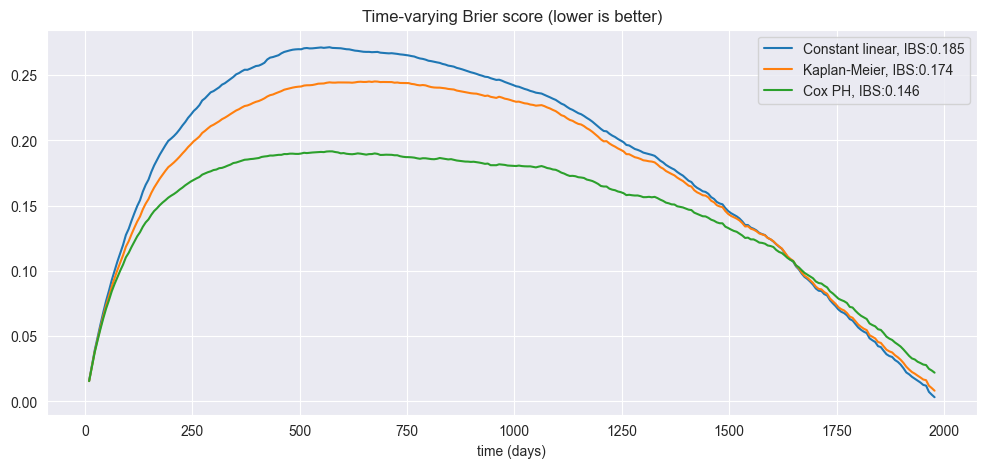

In [39]:
cox_survival_curves = np.vstack(
    [
        cox_ph_survival_func(time_grid)
        for cox_ph_survival_func in cox_ph_survival_funcs
    ]
)
evaluator("Cox PH", cox_survival_curves)

So the Cox Proportional Hazard model from scikit-survival fitted as a simple pipeline with one-hot encoded categorical variables and raw numerical variables seems already significantly better than our unconditional baseline.

**Exercise**

Let's define a more expressive polynomial feature engineering pipeline for a Cox PH model that:

- encodes categorical variables using the `OneHotEncoder` as previously;
- transforms numerical features with `SplineTransformer()` (using the default parameters);
- transforms the resulting of the encoded categorical variables and spline-transformed numerical variables using a degree 2 polynomial kernel approximation using the Nystroem method (e.g. `Nystroem(kernel="poly", degree=2, n_components=300)`)

In [40]:
X.columns

Index(['driver_skill', 'brand', 'truck_model', 'usage_rate'], dtype='object')

In [41]:
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem

# TODO: write your pipeline here.


# step 1: define a column transformer to:
# - one-hot encode categorical columns
# - spline-transform numerical features

# step 2: define a Nystroem approximate degree 2 polynomial feature expansion

# step 3: assemble everything in a pipeline with a CoxPHSurvivalAnalysis
# model at the end.

# step 4: fit the pipeline on the training set.

# step 5: predict the survival functions for each row of the test set.

# step 6: compute the values of the survival function on the usual `time_grid`
# and store the result in an array named `poly_cox_ph_survival_curves`.

# Uncomment the following to evaluate your pipeline:

# evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)

#### Solution

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1407,0.6979


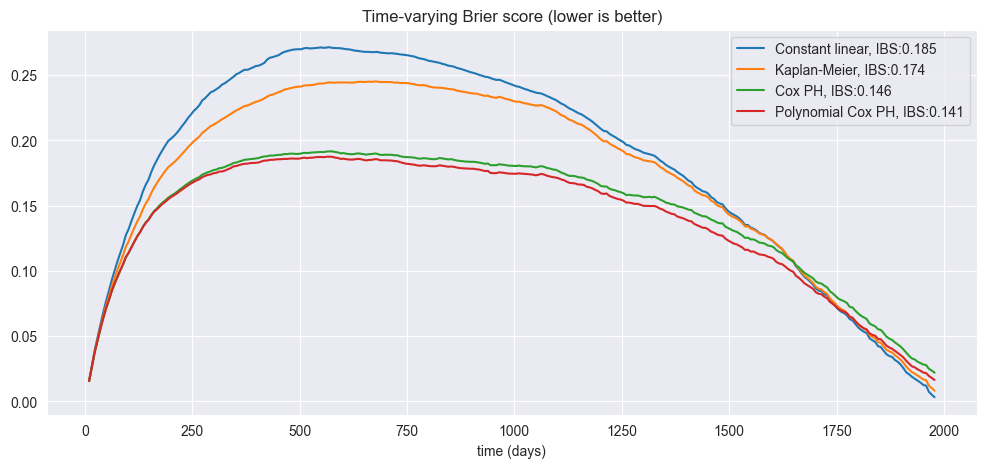

In [42]:
### Solution:

from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem


spline_preprocessor = make_column_transformer(
    (OneHotEncoder(), ["brand", "truck_model"]),
    (SplineTransformer(), ["driver_skill", "usage_rate"]),
    verbose_feature_names_out=False,
)
poly_cox_ph = make_pipeline(
    spline_preprocessor,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-2)
)
poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))
poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)


poly_cox_ph_survival_curves = np.vstack(
    [
        poly_cox_ph_survival_func(time_grid)
        for poly_cox_ph_survival_func in poly_cox_ph_survival_funcs
    ]
)
evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)

#### End solution

### Random Survival Forest

Random Survival Forests are non-parametric model that is potentially more expressive than Cox PH. In particular, if we expect that the shape of the time varying hazards are not the same for each individual, tree-based models such as RSF might perform better. In general they also require a large enough training set to avoid overfitting.

Note however that they are quite computational intensive and their training time can be prohibitive on very large dataset.

In [43]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(
    simple_preprocessor,
    RandomSurvivalForest(n_estimators=10, max_depth=8, n_jobs=-1),
)
rsf.fit(X_train, as_sksurv_recarray(y_train))

/Users/jalberge/anaconda3/envs/donnees_censurees/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('randomsurvivalforest',
                 RandomSurvivalForest(max_depth=8, n_estimators=10,
                                      n_jobs=-1))])

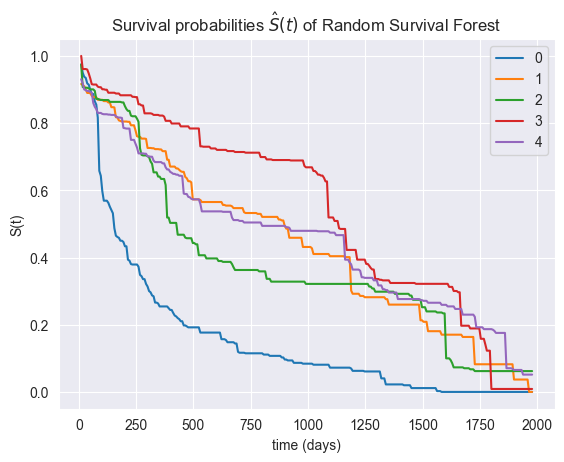

In [44]:
rsf_survival_funcs = rsf.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, survival_func in enumerate(rsf_survival_funcs[:5]):
    survival_curve = survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)
ax.set(
    title="Survival probabilities $\hat{S}(t)$ of Random Survival Forest",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

Indeed we observe that the shapes of the curves can vary more than for the Cox-PH model which is more constrained. Let's see if this flexibility makes it a better predictive model on aggregate on the test set:

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1407,0.6979
4,Random Survival Forest,0.1466,0.6805


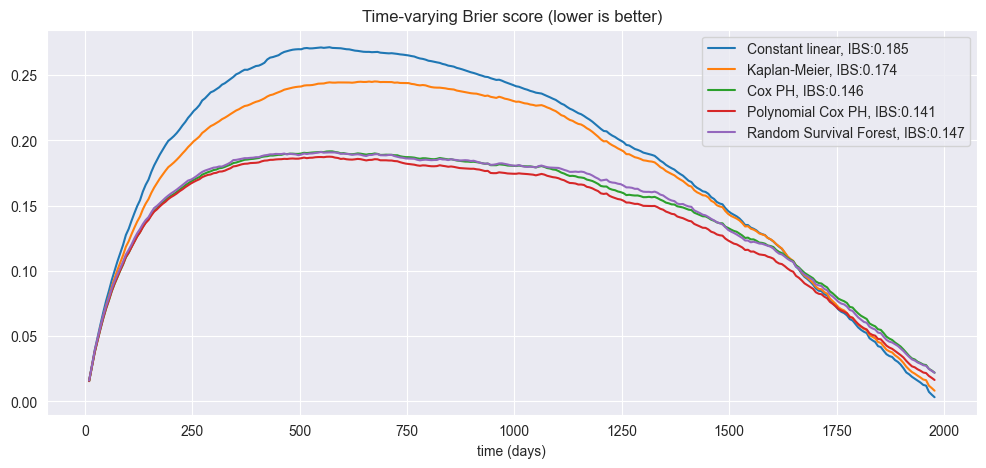

In [45]:
rsf_survival_curves = np.vstack(
    [func(time_grid) for func in rsf_survival_funcs]
)
evaluator("Random Survival Forest", rsf_survival_curves)

Unfortunately this does not seem to be able to significantly improve upon the Cox PH model as a ranking model.

### SurvivalBoost


We now introduce a novel survival estimator named Gradient Boosting CIF. This estimator is based on the `HistGradientBoostingClassifier` of scikit-learn under the hood. It is named `CIF` because it has the capability to estimate cause-specific Cumulative Incidence Functions in a competing risks setting by minimizing a cause specific IBS objective function.

Here we first introduce it as a conditional estimator of the any-event survival function by omitting the `event_of_interest` constructor parameter.

In [46]:
from hazardous import SurvivalBoost
from model_selection.wrappers import PipelineWrapper

sb = make_pipeline(
    simple_preprocessor,
    SurvivalBoost(),
)
sb = PipelineWrapper(sb)
sb.fit(X_train, y_train)

/Users/jalberge/anaconda3/envs/donnees_censurees/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


100%|██████████| 300/300 [00:04<00:00, 69.17it/s]


,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1407,0.6979
4,Random Survival Forest,0.1466,0.6805
5,SurvivalBoost,0.1411,0.6937


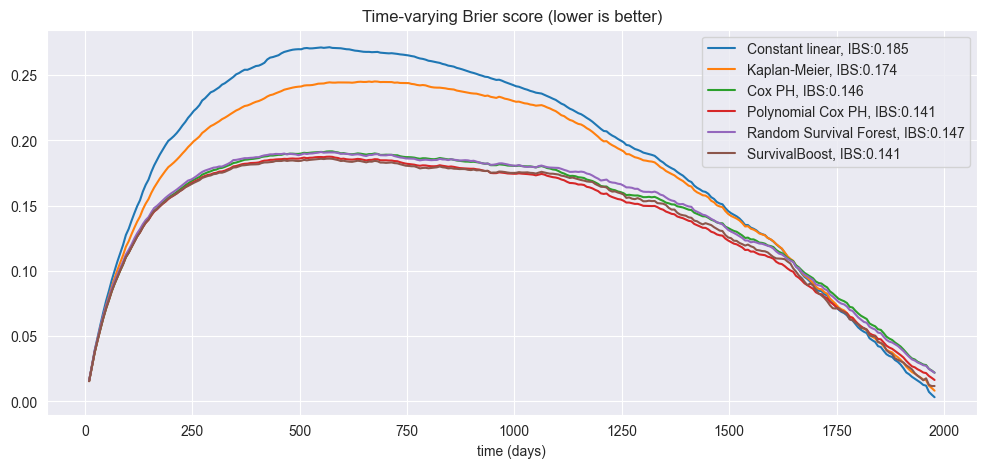

In [47]:
sb_cif_survival_curves = sb.predict_survival_function(X_test, time_grid)
evaluator("SurvivalBoost", sb_cif_survival_curves)

This model is often better than Random Survival Forest but significantly faster to train and requires few feature engineering than a Cox PH model.

Let's try to improve the performance of the models that train fast on a larger dataset. As the `truck_failure_100k` dataset is a superset of the `truck_failure_10k` dataset, we reuse the sample test sampples to simplify model evaluation:

In [48]:
truck_failure_100k_any_event = pd.read_parquet("truck_failure/truck_failure_100k_any_event.parquet")
truck_failure_100k_features = pd.read_parquet("truck_failure/truck_failure_100k_features.parquet")

train_large_mask = np.full(shape=truck_failure_100k_any_event.shape[0], fill_value=True)
train_large_mask[idx_test] = False
X_train_large = truck_failure_100k_features[train_large_mask]
y_train_large = truck_failure_100k_any_event[train_large_mask]

large_model_evaluator = SurvivalAnalysisEvaluator(y_train_large, y_test, time_grid)

In [49]:
X_train_large.shape

(92680, 4)

**Warning**: fitting polynomial Cox PH on the larger training set takes several minutes on a modern laptop. Feel free to skip.

In [50]:
poly_cox_ph_large_survival_curves = None

CPU times: user 1min 58s, sys: 18 s, total: 2min 16s
Wall time: 1min 51s


,Model,IBS,C-index
0,Polynomial Cox PH (larger training set),0.1405,0.6992


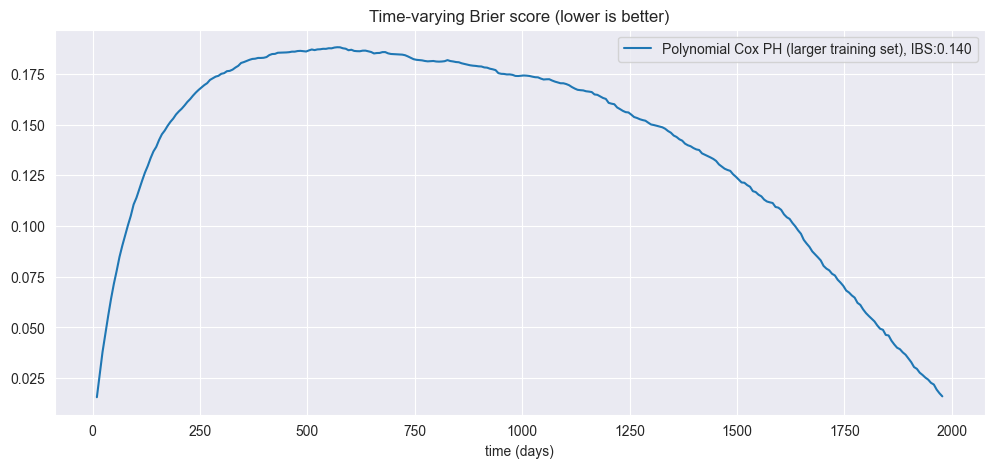

In [51]:
%%time
poly_cox_ph_large = make_pipeline(
    spline_preprocessor,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
poly_cox_ph_large.fit(X_train_large, as_sksurv_recarray(y_train_large))
poly_cox_ph_large_survival_funcs = poly_cox_ph_large.predict_survival_function(X_test)


poly_cox_ph_large_survival_curves = np.vstack(
    [
        f(time_grid) for f in poly_cox_ph_large_survival_funcs
    ]
)
large_model_evaluator("Polynomial Cox PH (larger training set)", poly_cox_ph_large_survival_curves)

Fitting `SurvivalBoost` on the larger dataset should take a fraction of a minute on a modern laptop:

/Users/jalberge/anaconda3/envs/donnees_censurees/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

100%|██████████| 300/300 [00:03<00:00, 91.03it/s]


CPU times: user 5min 8s, sys: 3min, total: 8min 8s
Wall time: 1min 2s


,Model,IBS,C-index
0,Polynomial Cox PH (larger training set),0.1405,0.6992
1,SurvivalBoost (larger training set),0.1401,0.6975


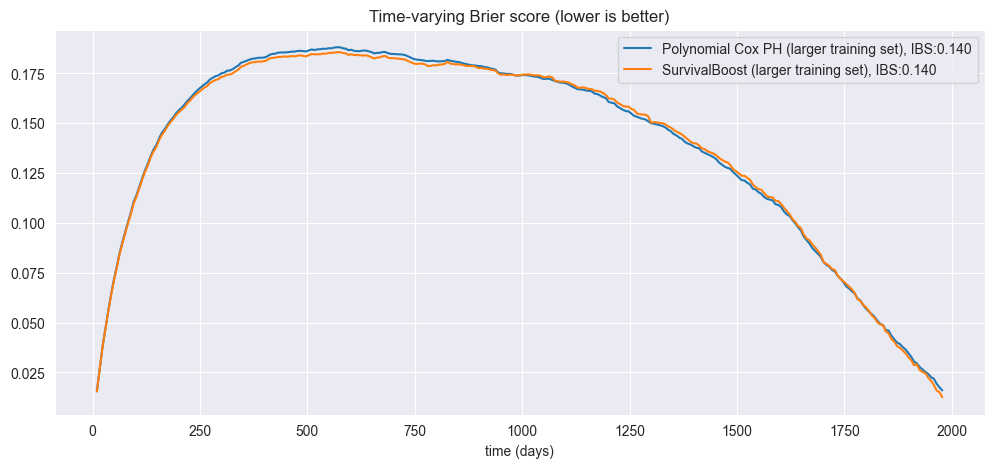

In [52]:
%%time
sb_large = make_pipeline(
    simple_preprocessor,
    SurvivalBoost(max_leaf_nodes=31, learning_rate=0.1, n_iter=100),
)
sb_large = PipelineWrapper(sb_large)
sb_large.fit(X_train_large, y_train_large, time_grid)
sb_large_survival_curves = sb_large.predict_survival_function(X_test, time_grid)

large_model_evaluator("SurvivalBoost (larger training set)", sb_large_survival_curves)

### Comparing our estimates to the theoretical survival curves

Since the dataset is synthetic, we can access the underlying hazard function for each row of `X_test`:

In [53]:
with np.load("truck_failure/truck_failure_10k_hazards.npz") as f:
    theoretical_hazards = f["truck_failure_10k_hazards"]
theoretical_hazards.shape

(3, 10000, 3650)

The first axis correspond to the 3 types of failures of this dataset (that will be covered in the next section). For now let's collapse them all together an consider the "any event" hazard functions:

In [54]:
any_event_hazards = theoretical_hazards.sum(axis=0)
any_event_hazards.shape

(10000, 3650)

We can then extra the test records:

In [55]:
any_event_hazards_test = any_event_hazards[idx_test]
any_event_hazards_test.shape

(7320, 3650)

and finally, do a numerical integration over the last dimension (using `cumsum(axis=-1)`) and take the exponential of the negative cumulated hazards to recover the theoretical survival curves for each sample of the test set:

In [56]:
theoretical_survival_curves = np.exp(-any_event_hazards_test.cumsum(axis=-1))
theoretical_survival_curves.shape

(7320, 3650)

Finally, we can evaluate the performance metrics (IBS and C-index) of the theoretical curves on the same test events and `time_grid` to be able to see how far our best predictive survival analysis models are from the optimal model:

In [57]:
time_grid.shape

(300,)

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1407,0.6979
4,Random Survival Forest,0.1466,0.6805
5,SurvivalBoost,0.1411,0.6937
6,Data generating process,0.1384,0.6987


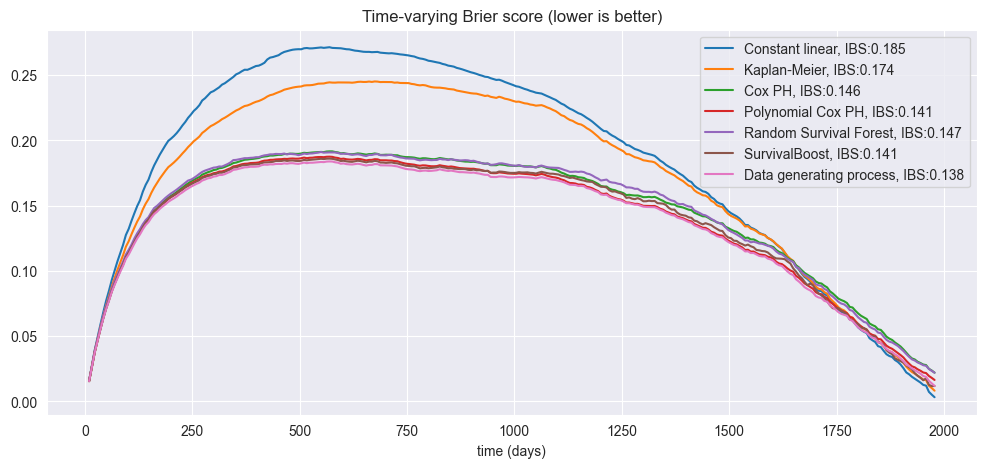

In [58]:
n_total_days = any_event_hazards.shape[-1]
original_time_range = np.linspace(0, n_total_days, n_total_days)

theoretical_survival_curves = np.asarray([
    interp1d(
        original_time_range,
        surv_curve,
        kind="previous",
        bounds_error=False,
        fill_value="extrapolate",
    )(time_grid) for surv_curve in theoretical_survival_curves
])

evaluator("Data generating process", theoretical_survival_curves)

The fact that the C-index of the Polynomial Cox PH model can some times be larger than the C-index of the theoretical curves is quite unexpected and would deserve further investigation. It could be an artifact of our evaluation on a finite size test set and the use of partially censored test data.

Let's also compare with the version of the model trained on the large dataset:

,Model,IBS,C-index
0,Polynomial Cox PH (larger training set),0.1405,0.6992
1,SurvivalBoost (larger training set),0.1401,0.6975
2,Data generating process,0.1387,0.6987


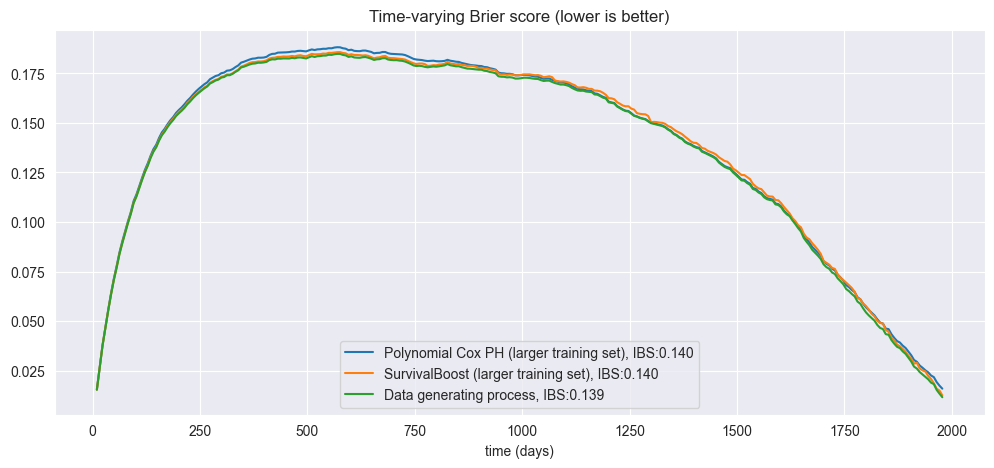

In [59]:
large_model_evaluator("Data generating process", theoretical_survival_curves)

We observe that our best models are quite close to the theoretical optimum but there is still some slight margin for improvement. It's possible that re-training the same model pipelines with even larger number of training data points or better choice of hyperparameters and feature preprocessing could help close that gap.

Note that the IBS and C-index values of the theoretical survival curves are far from 0.0 and 1.0 respectively: this is expected because not all the variations of the target `y` can be explained by the values of the columns of `X`: there is still a large irreducible amount of unpredictable variability (a.k.a. "noise") in this data generating process.

Since our estimators are conditional models, it's also interesting to compare the predicted survival curves for a few test samples and contrasting those to the
theoretical survival curves:

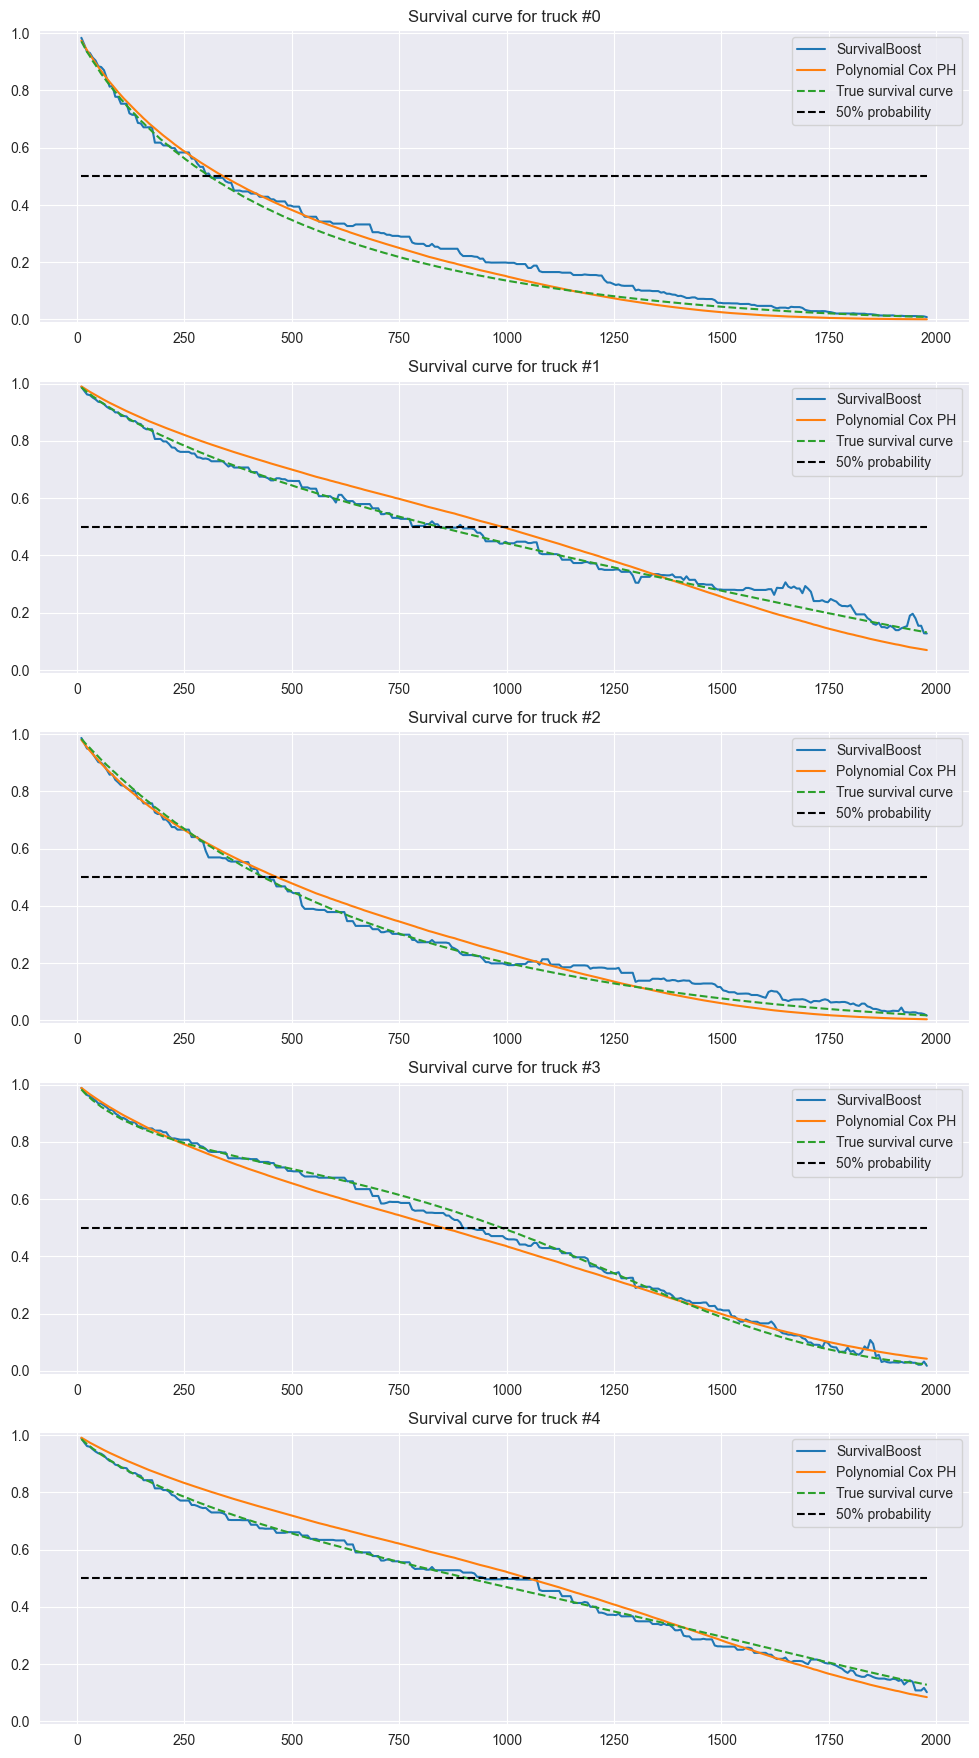

In [60]:
fig, axes = plt.subplots(nrows=5, figsize=(12, 22))

for sample_idx, ax in enumerate(axes):
    ax.plot(time_grid, sb_large_survival_curves[sample_idx], label="SurvivalBoost")
    if poly_cox_ph_large_survival_curves is not None:
        ax.plot(time_grid, poly_cox_ph_large_survival_curves[sample_idx], label="Polynomial Cox PH")
    ax.plot(time_grid, theoretical_survival_curves[sample_idx], linestyle="--", label="True survival curve")
    ax.plot(time_grid, 0.5 * np.ones_like(time_grid), linestyle="--", color="black", label="50% probability")
    ax.set(
        title=f"Survival curve for truck #{sample_idx}",
        ylim=[-.01, 1.01],
    )
    ax.legend()

The individual survival functions predicted by the polynomial Cox PH model are always smooth but we can observe that they do now always match the shape of the true survival curve on some test datapoints.

We can also observe that the individual survival curves of the Gradient Boosting CIF model **suffer from the constant-piecewise prediction function of the underlying decision trees**. But despite this limitation, this model still yields very good approximation to the true survival curves. In particular **they can provide competitive estimates of the median survival time** for instance.

Let's check this final asserion by comparing the Mean absolute error for the median survival time estimates for our various estimators. Note that we can only do this because our data is synthetic and we have access to the true median survival time derived from the data generating process.

In [61]:
from sklearn.metrics import mean_absolute_error

def quantile_survival_times(times, survival_curves, q=0.5):
    increasing_survival_curves = survival_curves[:, ::-1]
    median_indices = np.apply_along_axis(
        lambda a: a.searchsorted(q), axis=1, arr=increasing_survival_curves
    )
    return times[-median_indices]


def compute_quantile_metrics(evaluator):
    all_metrics = []
    for model_name, info in evaluator.model_data.items():
        survival_curves = info["survival_curves"]
        record = {"Model": model_name}
        for q in [0.25, 0.5, 0.75]:
            mae = mean_absolute_error(
                quantile_survival_times(time_grid, survival_curves, q=q),
                quantile_survival_times(time_grid, theoretical_survival_curves, q=q),
            )
            record[f"MAE for q={np.round(q, 2)}"] = np.round(mae, 1)
        all_metrics.append(record)
    return pd.merge(evaluator.metrics_table(), pd.DataFrame(all_metrics))


compute_quantile_metrics(evaluator)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.1854,0.5000,487.9,438.6,305.3
1,Kaplan-Meier,0.1739,0.5000,473.9,433.8,280.5
2,Cox PH,0.1460,0.6902,389.9,160.6,119.7
3,Polynomial Cox PH,0.1407,0.6979,188.4,103.9,103.3
4,Random Survival Forest,0.1466,0.6805,321.0,174.7,136.3
5,SurvivalBoost,0.1411,0.6937,166.1,103.3,73.2
6,Data generating process,0.1384,0.6987,0.0,0.0,0.0


In [62]:
compute_quantile_metrics(large_model_evaluator)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Polynomial Cox PH (larger training set),0.1405,0.6992,135.5,58.6,89.2
1,SurvivalBoost (larger training set),0.1401,0.6975,74.1,44.9,29.5
2,Data generating process,0.1387,0.6987,0.0,0.0,0.0


This confirms that the best estimators ranked by IBS computed on a censored test sample are the most accurately modeling the uncensored time-to-event distribution.

Furthermore, we observe that a small gain in IBS can have a significant impact in terms of MAE and SurvivalBoost can reduce its prediction error significantly by increasing the size of the training set and simultaneously increasing the number of leaf nodes per tree.

This is not the case of the Polynomial Cox PH model which seems to be intrisically limited by its core modeling assumption: the shape of the Cox PH hazard function depends on $t$ but is independent of $X$. If this assumption does not hold, no amount of additional training data will help the estimator reach the optimal IBS.

## Unconditional competing risks modeling with Aalen-Johanson

So far, we've been dealing with a single kind of risk: any accident. **What if we have different, mutually exclusive types of failure?**

This is the point of **competing risks modeling**. It aims at modeling the probability of incidence for different events, where these probabilities interfer with each other. Here we consider that a truck that had an accident is withdrawn from the fleet, and therefore can't experience any other ones.


Let's load our dataset another time. Notice that we have 3 types of event (plus the censoring 0):

In [63]:
truck_failure_competing_events = pd.read_parquet("truck_failure/truck_failure_10k_competing_risks.parquet")
truck_failure_competing_events

,event,duration
0,3,980.394661
1,2,1207.870100
2,0,125.000000
3,1,96.839004
4,2,88.077852
...,...,...
9995,2,0.435731
9996,2,356.591211
9997,1,847.951259
9998,2,25.551167


In this refined variant of the truck failure event data, the event identifiers mean the following:

- 1: manufacturing defect: a failure of a truck that happens as a result of mistakes in the assembly of the components (e.g. loose bolts);
- 2: operational failures, e.g. a driving accident;
- 3: fatigure induced failures, e.g. an engine breaks after heavy use for a prolongued period of time, despite good assembly and regular maintenance.

0 is still the censoring marker.

Instead of estimating a survival function (probability of remaining event free over time), a competing risk analysis model attempts to estimate a **cause-specific cumulative incidence function ($CIF_k$)**:

For any event $k \in [1, K]$, the cumulative incidence function of the event $k$ becomes:

$$CIF_k = P(T < t, \mathrm{event}=k)$$

In the unconditional case, the estimator ignore any side information in $X$ and only models $CIF_k(t)$ from information in $y$: event types and their respective durations (often with censoring).

**Aalen-Johanson estimates the CIF for multi-event $k$**, by:
- estimating the cause-specific hazards on one hand;
- estimating the global (any event) survival probabilities using Kaplan-Meier on the other hand.

The two estimates are then combined to produce an estimate of the cause-specific cumulative incidence.

<details><summary>Mathematical formulation</summary>
    
We first compute the cause-specific hazards $\lambda_k$, by simply counting for each individual duration $t_i$ the number of individuals that have experienced the event $k$ at $t_i$ ($d_{i,k}$), and the number of people still at risk at $t_i$ ($n_i$).

$$
\hat{\lambda}_k(t_i)=\frac{d_{k,i}}{n_i}
$$

Then, we compute the survival probability any event with Kaplan-Meier any event, where we can reused the cause-specific hazards.
    
$$
\hat{S}(t)=\prod_{i:t_i\leq t} (1 - \frac{d_i}{n_i})=\prod_{i:t_i\leq t} (1 - \sum_k\hat{\lambda}_{k}(t_i))
$$

Finally, we compute the CIF of event $k$ as the sum of the cause-specific hazards, weighted by the survival probabilities.

$$\hat{F}_k(t)=\sum_{i:t_i\leq t} \hat{\lambda}_k(t_i) \hat{S}(t_{i-1})$$
    
    
</details>

Let's use lifelines to estimate the ${CIF_k}$ using Aalen-Johanson. We need to indicate which event to fit on, so we'll iteratively fit the model on all events.

Fitting Aalen-Johansen for event 1...
Fitting Aalen-Johansen for event 2...
Fitting Aalen-Johansen for event 3...


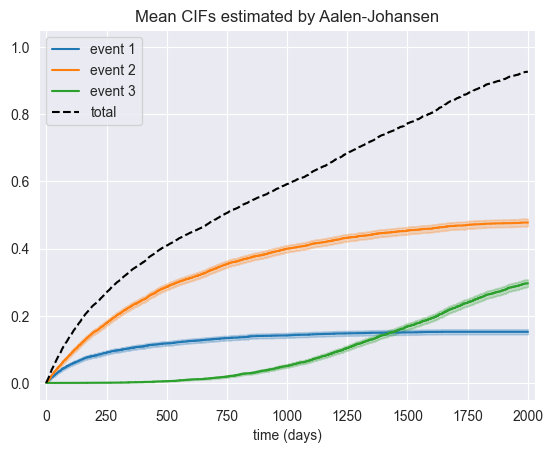

In [64]:
from lifelines import AalenJohansenFitter

fig, ax = plt.subplots()

total_cif = None
competing_risk_ids = sorted(
    truck_failure_competing_events.query("event > 0")["event"].unique()
)
for event in competing_risk_ids:
    print(f"Fitting Aalen-Johansen for event {event}...")
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(
        truck_failure_competing_events["duration"],
        truck_failure_competing_events["event"],
        event_of_interest=event
    )
    ajf.plot(ax=ax, label=f"event {event}")
    cif_df = ajf.cumulative_density_
    cif_times = cif_df.index
    if total_cif is None:
        total_cif = cif_df[cif_df.columns[0]].values
    else:
        total_cif += cif_df[cif_df.columns[0]].values

ax.plot(cif_times, total_cif, label="total", linestyle="--", color="black")
ax.set(
    title="Mean CIFs estimated by Aalen-Johansen",
    xlabel="time (days)",
    xlim=(-30, 2030),
    ylim=(-0.05, 1.05),
)
plt.legend();

This unconditional model helps us identify 3 types of events, having momentum at different times. As expected:

- the incidence of type 1 events (failures caused by manufactoring defects) increase quickly from the start and then quickly plateau: after 1000 days, the estimator expects almost no new type 1 event to occur: all trucks with a manufacturing defect should have failed by that time.
- the incidence of type 2 events (failures caused by wrong operation of the truck) constantly accumulate throughout the observation period.
- the incidence of type 3 events (fatigure induced failures) is almost null until 500 days and then slowly increase.

Note that once a truck as failed from one kind of event (e.g. a manufacturing defect), it is taken out of the pool of trucks under study and can therefore no longer experience any other kind of failures: there are therefore many operational or fatigure induced failures that do no happen because some trucks have previously failed from a competing failure type.

Finally, we can observe that, as time progresses, operational and, even more importantly, fatigue induced failures are expected to make all the trucks in the study fail. Therefore, the sum of the cumulative incidence functions is expected to reach 100% in our study in the large time limit.

However, since all events beyond 2000 days are censored in our dataset, the Aaelen-Johansen estimator produces truncated incidence curves: it does not attempt to extra polate beyond the maximum event time observed in the data.

## Predictive competing risks analysis using our SurvivalBoost

Contrary to predictive survival analysis, the open source ecosystem is not very mature for predictive competing risk analysis.

`SurvivalBoost` was designed to tacke each risk simutaneously.

In [65]:
y_train_cr = truck_failure_competing_events.loc[idx_train]
y_test_cr = truck_failure_competing_events.loc[idx_test]

sb = make_pipeline(
    simple_preprocessor,
    SurvivalBoost(
        max_leaf_nodes=15, n_iter=50, learning_rate=0.05
    ),
)
sb = PipelineWrapper(sb)
sb.fit(X_train, y_train_cr, time_grid)

/Users/jalberge/anaconda3/envs/donnees_censurees/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Once fit, we can use this family of model to predict individual CIF predictions for each kind of event. Plotting the average CIF across indiviuals in the test set should recover curves similar to the Aalean-Johansen estimates (in the limit of large training and test data).

The predictions in SurvivalBoost returns arrays where for each sample, the model will return K + 1 curves (the survival function, and the K curves for each competing event) at each time.

100%|██████████| 300/300 [00:07<00:00, 41.73it/s]


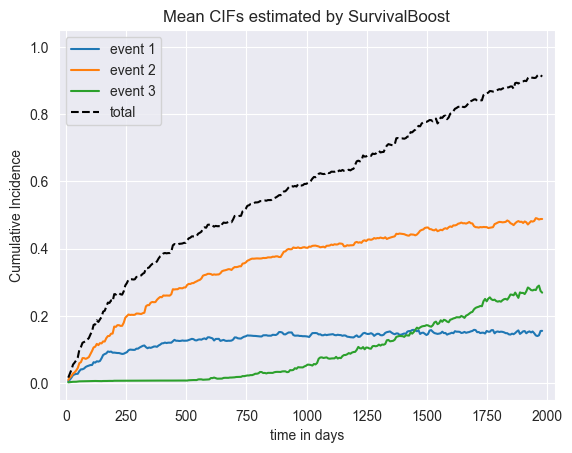

In [66]:
fig, ax = plt.subplots()
incidence_curves_sb = sb.predict_cumulative_incidence(X_test, time_grid)
total_mean_cif = np.zeros(time_grid.shape[0])
for k in competing_risk_ids:
    cif_curve_k = incidence_curves_sb[:, k, :]
    mean_cif_curve_k = cif_curve_k.mean(axis=0)  # average over test points
    ax.plot(time_grid, mean_cif_curve_k, label=f"event {k}")
    total_mean_cif += mean_cif_curve_k

ax.plot(time_grid, total_mean_cif, label="total", linestyle="--", color="black")
ax.set(
    title="Mean CIFs estimated by SurvivalBoost",
    xlabel="time in days",
    ylabel="Cumulative Incidence",
    xlim=(-30, 2030),
    ylim=(-0.05, 1.05),
)
plt.legend();

The average cause-specific cumulative incidence curves seems to mostly agree with the Aalen-Johansen estimate. One can observe some problematic discrepancy though (depending on the choice of the hyper-parameters):

- the cumulative incidence of event 1 and 2 do not start at 0 as expected;
- the cumulative incidence of event 1 seems to continue growing beyond day 1500 which is not expected either.

On aggregate we can therefore expect the total incidence to be over estimated on the edges of the time range.

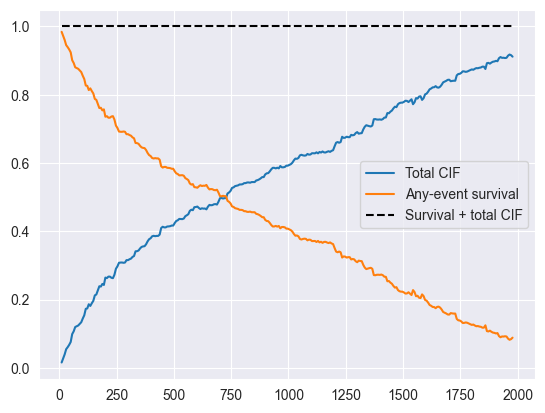

In [67]:
fig, ax = plt.subplots()
mean_survival_curve = incidence_curves_sb[:, 0, :].mean(axis=0)
ax.plot(time_grid, total_mean_cif, label="Total CIF")
ax.plot(time_grid, mean_survival_curve, label="Any-event survival")
ax.plot(
    time_grid,
    total_mean_cif + mean_survival_curve,
    color="black",
    linestyle="--",
    label="Survival + total CIF",
)
ax.legend();

### Model evaluation with the cause-specific Brier score

At this time, only hazardous provide an implementation of time-dependent Brier score adjusted for censoring in a competing risks setting.

Let's compute the theoretical cumulative incidence from the true hazards of the data generating process. We start from our theoretical hazards:

In [68]:
theoretical_hazards.shape

(3, 10000, 3650)

To derive the theoretical cumulative incidence curves, we need to estimate the true survival functions from the any-event hazards. Then we integrate over time the produce of the cause specific hazards with the any-event survival function to derive the cause-specific cumulative incidence.

We also need to interpolate them to our evaluation time grid.

Finally we compute the IBS both for the cumulative incidence curves predicted by our `SurvivalBoost` models and the curves derived from the the true hazards.

In [69]:
from hazardous.metrics import integrated_brier_score_incidence


any_event_hazards = theoretical_hazards.sum(axis=0)
true_survival = np.exp(-any_event_hazards.cumsum(axis=-1))

for k in competing_risk_ids:
    # Compute the integrated 
    sb_ibs_k = integrated_brier_score_incidence(
        y_train_cr,
        y_test_cr,
        incidence_curves_sb[:, k, :],
        time_grid,
        event_of_interest=k,
    )
    # Evaluate the interpolated cumulative incidence curve on the same
    # test set:
    theoretical_cumulated_incidence_curves_k = np.asarray([
        interp1d(
            original_time_range,
            ci_curve,
            kind="previous",
            bounds_error=False,
            fill_value="extrapolate",
        )(time_grid)
        for ci_curve in (theoretical_hazards[k - 1] * true_survival).cumsum(axis=-1)[idx_test]
    ])
    theoretical_cif_ibs_k = integrated_brier_score_incidence(
        y_train_cr,
        y_test_cr,
        theoretical_cumulated_incidence_curves_k,
        time_grid,
        event_of_interest=k,
    )
    print(
        f"[event {k}] IBS for SurvivalBoost: {sb_ibs_k:.4f}, "
        f"IBS for True CIF: {theoretical_cif_ibs_k:.4f}"
    )

[event 1] IBS for SurvivalBoost: 0.0993, IBS for True CIF: 0.0988
[event 2] IBS for SurvivalBoost: 0.1237, IBS for True CIF: 0.1214
[event 3] IBS for SurvivalBoost: 0.0557, IBS for True CIF: 0.0548


By looking at the cause-specific IBS values, it seems that our model is already quite close to the optimal. Again, it's likely that this can be improved by increasing the training set size and tuning the hyper-parameters.

***Exercise***

For each type of event and each datapoint in the test set, predict the time-to-event for a quantile of your choice. 

Then compare to the corresponding quantile of the time-to-event derived from the theoretical cumulative incidence curves.

*Hint* do you expect quantile choices that yield undefined values? If so, how sensitive are each types of event to the choice of quantile?

In [70]:
# compute quantile time-to-event predicted by model

# TODO

In [71]:
# measure quantile time-to-event on uncensored data


# TODO

In [72]:
# compare the predictions with expected values, for instance using the mean absolute error metric


# TODO






## Going further

We encourage you to dive deeper in the documentation of the [lifelines](https://lifelines.readthedocs.io) and [scikit-survival](https://scikit-survival.readthedocs.io/) packages.

You might be interested in the following notable alternatives not presented in this notebook:

- XGBoost has a builtin handling of [survival analysis with censored data](https://xgboost.readthedocs.io/en/stable/tutorials/aft_survival_analysis.html). However it does only provide predictions at fixed time horizons and does not attempt to estimate the full survival function.
- [XGBoost Survival Embeddings](https://loft-br.github.io/xgboost-survival-embeddings/index.html): another way to leverage gradient boosting for survival analysis.
- [DeepHit](https://github.com/chl8856/DeepHit): neural network based, typically with good ranking power but not necessarily well calibrated. Can also handle competing risks.
- [SurvTRACE](https://github.com/RyanWangZf/SurvTRACE): more recent transformer-based model. Can also handle competing risks. We did not yet evaluate how this performs from a calibration point of view (e.g. using cause-specific IBS).